<a href="https://colab.research.google.com/github/deondmello16/PyTorch-Journey/blob/main/PyTrochCustomDatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Datasets

In this notebook I'll practice how to build custom datasets and use it with pytorch.
I'll build a multiclass food classification model, like [nutrify](nutrify.app). Just a smaller version with just 3 classes.
They are:
* Pizza
* Stake
* Sushi

There are a few packages that are used along side PyTorch to create datsets. They are:
* `TorchVision`
* `TorchText`
* `TorchAudio`
* `TorchRec`

We'll also subclass `torch.untils.data.DataLoaders` to customize the dataset to our liking and need.

| Topic	| Contents |
|-------|------------|
| 0. Importing PyTorch and setting up device-agnostic code |	Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.|
| 1. Get data |	We're going to be using our own custom dataset of pizza, steak and sushi images. |
| 2. Become one with the data (data preparation) |	At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| 3. Transforming data |	Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to transform our images so they're ready to be used with a model. |
| 4. Loading data with ImageFolder (option 1) |	PyTorch has many in-built data loading functions for common types of data. ImageFolder is helpful if our images are in standard image classification format. |
| 5. Loading image data with a custom Dataset	| What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of torch.utils.data.Dataset.|
| 6. Other forms of transforms (data augmentation) |	Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of torchvision's in-built data augmentation functions. |
| 7. Model 0: TinyVGG without data augmentation	| By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| 8. Exploring loss curves |	Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is underfitting or overfitting. |
| 9. Model 1: TinyVGG with data augmentation	| By now, we've tried a model without, how about we try one with data augmentation?|
| 10. Compare model results |	Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| 11. Making a prediction on a custom image	| Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image outside of our existing dataset.|

## Import `pytorch` and set `device mode`

In [1]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
!mkdir data/
!wget https://github.com/deondmello16/PyTorch-Journey/raw/main/data/pizza_steak_sushi.zip
!mv pizza_steak_sushi.zip data/
import zipfile
with zipfile.ZipFile("data/pizza_steak_sushi.zip") as file:
  file.extractall(path="data/pizza_steak_sushi")
! ls -la data

--2024-02-13 04:31:06--  https://github.com/deondmello16/PyTorch-Journey/raw/main/data/pizza_steak_sushi.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/deondmello16/PyTorch-Journey/main/data/pizza_steak_sushi.zip [following]
--2024-02-13 04:31:06--  https://raw.githubusercontent.com/deondmello16/PyTorch-Journey/main/data/pizza_steak_sushi.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15737296 (15M) [application/zip]
Saving to: ‘pizza_steak_sushi.zip’

pizza_steak_sushi.z 100%[===================>]  15.01M  40.4MB/s    in 0.4s    

2024-02-13 04:31:08 (40.4 MB/s) - ‘pizza_steak_sushi

In [3]:
import os

next(os.walk('data/pizza_steak_sushi'))

('data/pizza_steak_sushi', ['test', 'train'], [])

In [4]:
data_path = "data/pizza_steak_sushi/"

def dir_walk(dir):
  for dir_path, dir_names, filenames in os.walk(dir):
    print(f" In path \"{dir_path}\", {len(dir_names) } directories and {len(filenames)} files.\n\n")

dir_walk(data_path)

 In path "data/pizza_steak_sushi/", 2 directories and 0 files.


 In path "data/pizza_steak_sushi/test", 3 directories and 0 files.


 In path "data/pizza_steak_sushi/test/sushi", 0 directories and 31 files.


 In path "data/pizza_steak_sushi/test/steak", 0 directories and 19 files.


 In path "data/pizza_steak_sushi/test/pizza", 0 directories and 25 files.


 In path "data/pizza_steak_sushi/train", 3 directories and 0 files.


 In path "data/pizza_steak_sushi/train/sushi", 0 directories and 72 files.


 In path "data/pizza_steak_sushi/train/steak", 0 directories and 75 files.


 In path "data/pizza_steak_sushi/train/pizza", 0 directories and 78 files.




## Viewing the data

In [5]:
from pathlib import Path

train_dir = Path("data/pizza_steak_sushi/train")
test_dir = Path("data/pizza_steak_sushi/test")

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

sushi


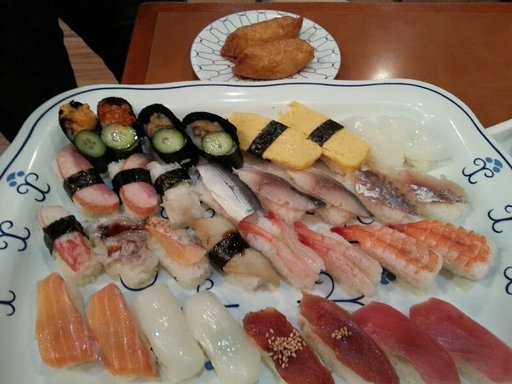

In [6]:
import random
from PIL import Image

image_path = Path('data/pizza_steak_sushi/')

image_path_list = list(image_path.glob('*/*/*.jpg'))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(image_class)
img

## 3. Tranforming data

We'll be taking help of a few liberies that come with torch lib to make augmented datasets.

There are appropriate datasets for each categories.

| Problem space	| Pre-built Datasets and Functions |
|----------------|----------------------------------|
| Vision	| `torchvision.datasets` |
| Audio |	`torchaudio.datasets` |
| Text	| `torchtext.datasets` |
|Recommendation system |	`torchrec.datasets` |

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [60]:
# make a tranform for image

tranformer = transforms.Compose([
    transforms.Resize(size=(64,64),antialias=True),
    transforms.RandomHorizontalFlip(p=0.5,),
    transforms.ToTensor(),
])

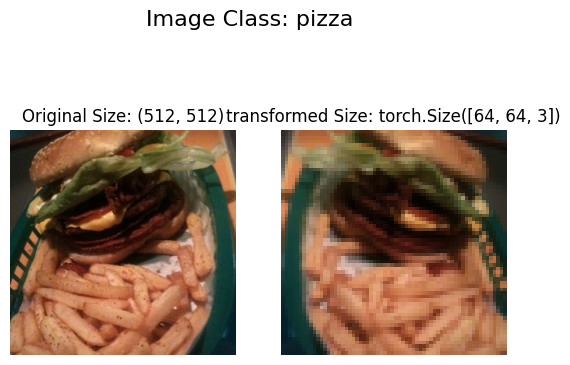

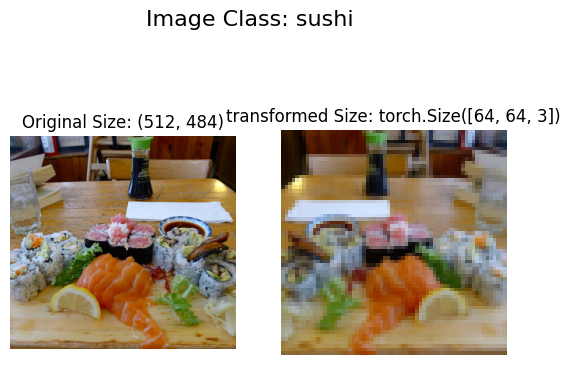

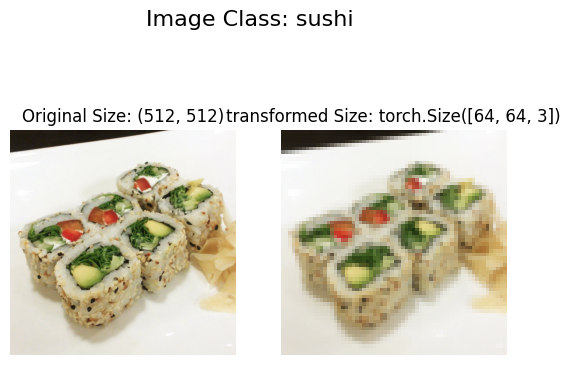

In [61]:
import matplotlib.pyplot as plt

def transformed_image(image_paths,transforms,n=3,seed=42):
  random.seed(seed)
  random_image_list = random.sample(image_paths,k=n)

  for image_path in random_image_list:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original Size: {f.size}") ## we use `f.size` because `f` is still a PIL object
      ax[0].axis('off')

      transformed_image = transforms(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"transformed Size: {transformed_image.shape}") # we use shape as `f` PIL obj is now a torch.Tensor obj
      ax[1].axis('off')

      fig.suptitle(f"Image Class: {image_path.parent.stem}", fontsize = 16)

transformed_image(image_path_list, tranformer)

## Loading Image Data using `ImageFolder`

The function is from the sub-class of `torchvision.datasets.ImageFolder`

In [62]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(
    root = train_dir,
    transform = tranformer,
    target_transform = None,
)
test_data = ImageFolder(
    root = test_dir,
    transform = tranformer,
    target_transform = None,
)

In [63]:
print(f"{train_data}")
print(f"{test_data}")

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [64]:
# view the classes

train_data.classes

['pizza', 'steak', 'sushi']

In [65]:
# classes to idx

train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [66]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original Image shape: torch.Size([3, 64, 64])
Image permute shape: torch.Size([64, 64, 3])


(-0.5, 63.5, 63.5, -0.5)

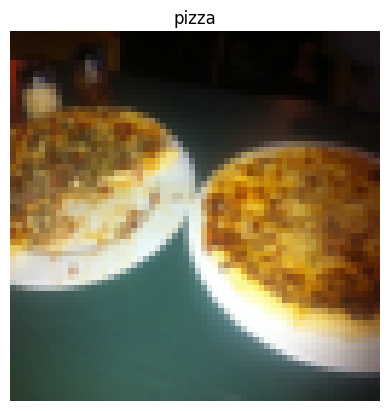

In [67]:
img_new = torch.permute(img,(1,2,0))

print(f"Original Image shape: {img.shape}")
print(f"Image permute shape: {img_new.shape}")

plt.imshow(img_new)
plt.title(train_data.classes[label])
plt.axis(False)

### Turn loaded images into `DataLoader`

Augmented data (`Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()`)

In [68]:
import os
os.cpu_count()

2

In [69]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = 32,
    shuffle = True,
    num_workers = os.cpu_count()//2,
)
test_dataloader = DataLoader(
    dataset = train_data,
    batch_size = 32,
    shuffle = True,
    num_workers = os.cpu_count()//2,
)

In [70]:
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cfa1dd5b9d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7cfa1dd3b8e0>)

## Model 0: Building TinyVGG model

1. create a transform (simple data augmentation)
2. Load the data into `ImageFolder` and then `DataLoader`
3. Create a VGG model class
4. Experiment with it by trying to forward pass a image and seeing the results
5. Create train and test loop (build custom functions)
6. train and evaluate the model
7. plot the model curves of `model_0`

### 1. Make a simple transform

In [71]:
from torchvision import transforms

simple_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64),antialias=True),
],)

simple_transformer

Compose(
    ToTensor()
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
)

In [72]:
from torchvision.datasets import ImageFolder

train_data_simple = ImageFolder(
    root = train_dir,
    transform = simple_transformer,
)

test_data_simple = ImageFolder(
    root = test_dir,
    transform = simple_transformer,
)

train_data_simple,test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
            ))

##### Simple augmented data

In [73]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS,)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)

In [74]:
train_dataloader_simple,test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7cfa2001c820>,
 <torch.utils.data.dataloader.DataLoader at 0x7cfa17748f40>)

### Creating the TinyVGG model

In [215]:
# from torch import nn

# class TinyVGG(nn.Module):
#   def __init__(self, input_shape : int, hidden_units : int , output_shape : int):
#     super().__init__()

#     self.conv_block_1 = nn.Sequential(
#         nn.Conv2d(in_channels = input_shape,
#                   out_channels = hidden_units,
#                   kernel_size = 3,
#                   stride = 1,
#                   padding = 1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels = hidden_units,
#                   out_channels = hidden_units,
#                   kernel_size = 3,
#                   stride = 1,
#                   padding = 1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size = 2,
#                         stride = 2)
#     )
#     self.conv_block_2 = nn.Sequential(
#         nn.Conv2d(in_channels = hidden_units,
#                   out_channels = hidden_units,
#                   kernel_size = 3,
#                   stride = 1,
#                   padding = 1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels = hidden_units,
#                   out_channels = hidden_units,
#                   kernel_size = 3,
#                   stride = 1,
#                   padding = 1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size = 2,
#                         stride = 2)
#     )


#     self.classifier = nn.Sequential(
#         nn.Flatten(),
#         # The in_features parameter is determined by the output size
#         # of the last convolutional layer (conv_block_2).
#         # It is computed as the number of channels (hidden_units) multiplied
#         # by the spatial resolution (16*16) of the feature map.
#         # The spatial resolution is reduced due to max-pooling layers
#         # in conv_block_1 and conv_block_2, each with a kernel size of 2.
#         # eg. image dim is 64,64 the maxpooling willreduce it by 64/(2*2) both width and height
#         nn.Linear(in_features = hidden_units*16*16, out_features = output_shape)
#     )


#   def forward(self,x : torch.Tensor) -> torch.Tensor:
#     x = self.conv_block_1(x)
#     x = self.conv_block_2(x)
#     return self.classifier(x)

from torch.nn import Module, Sequential, Conv2d, ReLU, MaxPool2d, Linear, BatchNorm2d, Dropout

class MoreFeatureCaptureVGG(Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.conv_block_1 = Sequential(
            Conv2d(input_shape, hidden_units, 5, 1, 2),
            BatchNorm2d(hidden_units),
            ReLU(),
            Conv2d(hidden_units, hidden_units, 5, 1, 2),
            BatchNorm2d(hidden_units),
            ReLU(),
            MaxPool2d(2, 2)
        )

        self.conv_block_2 = Sequential(
            Conv2d(hidden_units, hidden_units * 2, 5, 1, 2),
            BatchNorm2d(hidden_units * 2),
            ReLU(),
            Conv2d(hidden_units * 2, hidden_units * 2, 5, 1, 2),
            BatchNorm2d(hidden_units * 2),
            ReLU(),
            MaxPool2d(2, 2)
        )

        self.conv_block_3 = Sequential(
            Conv2d(hidden_units * 2, hidden_units * 4, 5, 1, 2),
            BatchNorm2d(hidden_units * 4),
            ReLU(),
            Conv2d(hidden_units * 4, hidden_units * 4, 5, 1, 2),
            BatchNorm2d(hidden_units * 4),
            ReLU(),
            MaxPool2d(2, 2)
        )

        self.classifier = Sequential(
            nn.Flatten(),
            Linear(hidden_units * 4 * 8 * 8, hidden_units * 4),
            ReLU(),
            Dropout(0.5),
            Linear(hidden_units * 4, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        return self.classifier(x)


In [204]:
model_0 = TinyVGG(input_shape = 3, hidden_units = 10, output_shape=3)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [205]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0547,  0.0069, -0.0357]])

Output prediction probabilities:
tensor([[0.3488, 0.3325, 0.3187]])

Output prediction label:
tensor([0])

Actual label:
1


In [206]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [175]:


torch.device

torch.device

In [176]:
from tqdm.auto import tqdm

def train_step(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_fn : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    device : torch.device = device):

  model.train()

  train_acc,train_loss = 0,0

  for batch ,(X,y) in tqdm(enumerate(dataloader)):

    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += ((y_pred == y).sum().item()/len(y_pred))

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [177]:
def test_step(model : torch.nn.Module,
              loss_fn : torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              device : torch.device = device):
  from torch.optim.lr_scheduler import ReduceLROnPlateau

  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
  model.eval()

  test_loss = test_acc = 0

  with torch.inference_mode():
    for (X,y) in dataloader:

      X, y = X.to(device), y.to(device)
      test_preds = model(X)

      loss = loss_fn(test_preds, y)
      test_loss+=loss.item()

      scheduler.step(loss.item())

      test_preds_labels = test_preds.argmax(dim =1)

      test_acc += ((test_preds_labels == y).sum().item()/len(test_preds_labels))

  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)

  return test_loss, test_acc

In [178]:
def model_train(model : torch.nn.Module,
                optimizer : torch.optim.Optimizer,
                train_dataloader : torch.utils.data.DataLoader,
                test_dataloader : torch.utils.data.DataLoader,
                epochs : int = 5,
                device : torch.device = device,
                loss_fn : torch.nn.Module = nn.CrossEntropyLoss(),
                ):
  results = {
      "train_loss" : [],
      "train_acc" : [],
      "test_loss" : [],
      "test_acc" : []
  }

  for epoch in tqdm(range(1, epochs+1)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device
                                       )

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)


    print(
        f"Epoch: {epoch} | "
        f"Train Loss: {train_loss:.4} | "
        f"Train Accuracy: {train_acc:.4} | "
        f"Test Loss: {test_loss:.4} | "
        f"Test Accuracy: {test_acc:.4} |"
    )

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)
  return results

In [179]:
torch.manual_seed(42)
if device == "cuda":
  torch.cuda.manual_seed(42)


model_0 = TinyVGG(input_shape=3, hidden_units = 10, output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [207]:
NUMS_EPOCH = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

model_0_results = model_train(model=model_0,
                              train_dataloader=train_dataloader_simple,
                              test_dataloader=test_dataloader_simple,
                              epochs=NUMS_EPOCH,
                              loss_fn=loss_fn,
                              optimizer = optimizer
                              )



  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | Train Loss: 1.105 | Train Accuracy: 0.25 | Test Loss: 1.125 | Test Accuracy: 0.2604 |


0it [00:00, ?it/s]

Epoch: 2 | Train Loss: 1.11 | Train Accuracy: 0.3047 | Test Loss: 1.115 | Test Accuracy: 0.2604 |


0it [00:00, ?it/s]

Epoch: 3 | Train Loss: 1.094 | Train Accuracy: 0.4258 | Test Loss: 1.093 | Test Accuracy: 0.2604 |


0it [00:00, ?it/s]

Epoch: 4 | Train Loss: 1.09 | Train Accuracy: 0.4258 | Test Loss: 1.095 | Test Accuracy: 0.2604 |


0it [00:00, ?it/s]

Epoch: 5 | Train Loss: 1.115 | Train Accuracy: 0.3047 | Test Loss: 1.111 | Test Accuracy: 0.2604 |


In [181]:
model_0_results

{'train_loss': [1.1078308075666428,
  1.084732174873352,
  1.1154007762670517,
  1.0974988043308258,
  1.0991295725107193],
 'train_acc': [0.2578125, 0.42578125, 0.29296875, 0.4140625, 0.29296875],
 'test_loss': [1.1362406015396118,
  1.1618939240773518,
  1.169935901959737,
  1.1361244122187297,
  1.142420808474223],
 'test_acc': [0.2604166666666667,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666]}

In [182]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)

In [183]:
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107831,0.257812,1.136241,0.260417
1,1.084732,0.425781,1.161894,0.197917
2,1.115401,0.292969,1.169936,0.197917
3,1.097499,0.414062,1.136124,0.197917
4,1.099130,0.292969,1.142421,0.197917


Text(0.5, 1.0, 'model_1_results')

<Figure size 700x700 with 0 Axes>

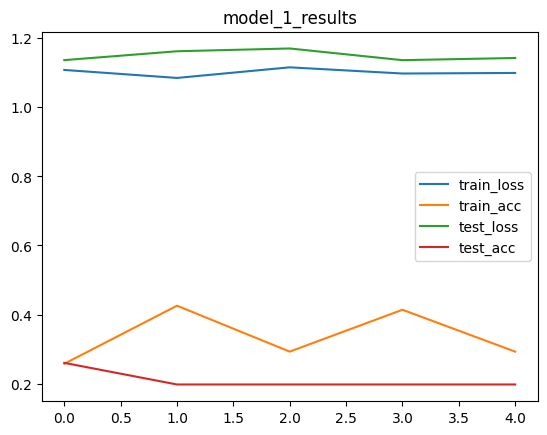

In [184]:
import matplotlib.pyplot as plt

plt.figure(figsize = (7,7))
model_0_df.plot()
plt.title("model_1_results")

<Axes: >

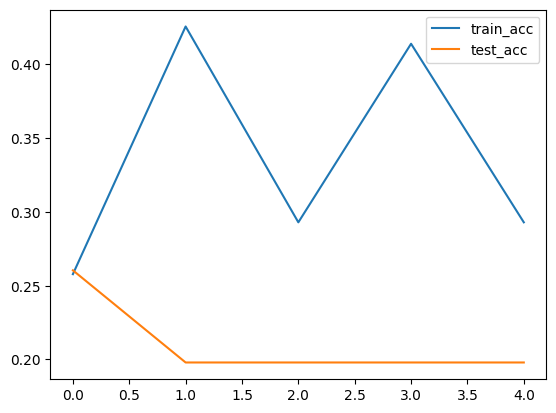

In [185]:
model_0_df[['train_acc','test_acc']].plot()

<Axes: >

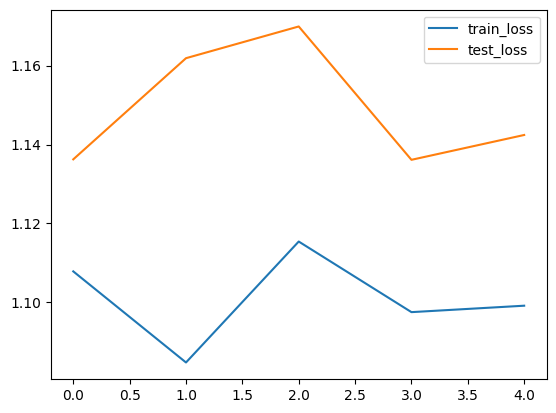

In [186]:
model_0_df[['train_loss','test_loss']].plot()

## Building Model 2: TinyVGG with `TrivialAugmentWide()`

###Creating a aug_transfrom

In [194]:
train_transform_trivial_augment  = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 50),
    transforms.ToTensor(),
])
test_transform_trivial_augment  = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

In [195]:
train_transform_trivial_augment,test_transform_trivial_augment

(Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
     TrivialAugmentWide(num_magnitude_bins=50, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
 ))

In [196]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform_trivial_augment)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=50, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [197]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cfa035c3940>,
 <torch.utils.data.dataloader.DataLoader at 0x7cfa1dd3b8e0>)

In [216]:
torch.manual_seed(42)
model_1 = MoreFeatureCaptureVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

MoreFeatureCaptureVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequ

In [213]:
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [217]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = model_train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | Train Loss: 1.422 | Train Accuracy: 0.2891 | Test Loss: 1.118 | Test Accuracy: 0.1979 |


0it [00:00, ?it/s]

Epoch: 2 | Train Loss: 1.09 | Train Accuracy: 0.3867 | Test Loss: 1.134 | Test Accuracy: 0.2604 |


0it [00:00, ?it/s]

Epoch: 3 | Train Loss: 1.135 | Train Accuracy: 0.3203 | Test Loss: 1.073 | Test Accuracy: 0.3542 |


0it [00:00, ?it/s]

Epoch: 4 | Train Loss: 1.019 | Train Accuracy: 0.5195 | Test Loss: 1.028 | Test Accuracy: 0.4347 |


0it [00:00, ?it/s]

Epoch: 5 | Train Loss: 0.9957 | Train Accuracy: 0.5195 | Test Loss: 1.11 | Test Accuracy: 0.3438 |


0it [00:00, ?it/s]

Epoch: 6 | Train Loss: 1.049 | Train Accuracy: 0.5117 | Test Loss: 1.075 | Test Accuracy: 0.3438 |


0it [00:00, ?it/s]

Epoch: 7 | Train Loss: 1.078 | Train Accuracy: 0.4531 | Test Loss: 1.043 | Test Accuracy: 0.3532 |


0it [00:00, ?it/s]

Epoch: 8 | Train Loss: 1.079 | Train Accuracy: 0.4062 | Test Loss: 0.9999 | Test Accuracy: 0.4441 |


0it [00:00, ?it/s]

Epoch: 9 | Train Loss: 1.015 | Train Accuracy: 0.4727 | Test Loss: 1.041 | Test Accuracy: 0.3428 |


0it [00:00, ?it/s]

Epoch: 10 | Train Loss: 0.908 | Train Accuracy: 0.5898 | Test Loss: 0.9591 | Test Accuracy: 0.5975 |


0it [00:00, ?it/s]

Epoch: 11 | Train Loss: 1.036 | Train Accuracy: 0.4531 | Test Loss: 0.9591 | Test Accuracy: 0.4536 |


0it [00:00, ?it/s]

Epoch: 12 | Train Loss: 0.8995 | Train Accuracy: 0.5586 | Test Loss: 0.9699 | Test Accuracy: 0.5663 |


0it [00:00, ?it/s]

Epoch: 13 | Train Loss: 1.014 | Train Accuracy: 0.4336 | Test Loss: 0.9951 | Test Accuracy: 0.5161 |


0it [00:00, ?it/s]

Epoch: 14 | Train Loss: 0.9497 | Train Accuracy: 0.5781 | Test Loss: 0.9913 | Test Accuracy: 0.4337 |


0it [00:00, ?it/s]

Epoch: 15 | Train Loss: 0.9501 | Train Accuracy: 0.582 | Test Loss: 1.198 | Test Accuracy: 0.3324 |


0it [00:00, ?it/s]

Epoch: 16 | Train Loss: 0.9708 | Train Accuracy: 0.4648 | Test Loss: 1.126 | Test Accuracy: 0.3722 |


0it [00:00, ?it/s]

Epoch: 17 | Train Loss: 0.879 | Train Accuracy: 0.5938 | Test Loss: 0.9354 | Test Accuracy: 0.4953 |


0it [00:00, ?it/s]

Epoch: 18 | Train Loss: 0.8536 | Train Accuracy: 0.6055 | Test Loss: 0.9855 | Test Accuracy: 0.4735 |


0it [00:00, ?it/s]

Epoch: 19 | Train Loss: 0.9312 | Train Accuracy: 0.4453 | Test Loss: 1.232 | Test Accuracy: 0.3523 |


0it [00:00, ?it/s]

Epoch: 20 | Train Loss: 0.9772 | Train Accuracy: 0.4609 | Test Loss: 1.184 | Test Accuracy: 0.392 |


0it [00:00, ?it/s]

Epoch: 21 | Train Loss: 1.011 | Train Accuracy: 0.4297 | Test Loss: 1.085 | Test Accuracy: 0.4328 |


0it [00:00, ?it/s]

Epoch: 22 | Train Loss: 0.893 | Train Accuracy: 0.4961 | Test Loss: 0.9887 | Test Accuracy: 0.4555 |


0it [00:00, ?it/s]

Epoch: 23 | Train Loss: 0.8523 | Train Accuracy: 0.6055 | Test Loss: 1.071 | Test Accuracy: 0.4138 |


0it [00:00, ?it/s]

Epoch: 24 | Train Loss: 0.9141 | Train Accuracy: 0.625 | Test Loss: 0.9231 | Test Accuracy: 0.5066 |


0it [00:00, ?it/s]

Epoch: 25 | Train Loss: 1.121 | Train Accuracy: 0.4492 | Test Loss: 0.9988 | Test Accuracy: 0.4044 |


0it [00:00, ?it/s]

Epoch: 26 | Train Loss: 0.9129 | Train Accuracy: 0.4922 | Test Loss: 1.015 | Test Accuracy: 0.375 |


0it [00:00, ?it/s]

Epoch: 27 | Train Loss: 0.9202 | Train Accuracy: 0.6172 | Test Loss: 1.078 | Test Accuracy: 0.4356 |


0it [00:00, ?it/s]

Epoch: 28 | Train Loss: 0.9685 | Train Accuracy: 0.4688 | Test Loss: 0.9971 | Test Accuracy: 0.3958 |


0it [00:00, ?it/s]

Epoch: 29 | Train Loss: 0.8662 | Train Accuracy: 0.6055 | Test Loss: 1.021 | Test Accuracy: 0.3835 |


0it [00:00, ?it/s]

Epoch: 30 | Train Loss: 0.8963 | Train Accuracy: 0.4961 | Test Loss: 1.004 | Test Accuracy: 0.4138 |


0it [00:00, ?it/s]

Epoch: 31 | Train Loss: 0.9181 | Train Accuracy: 0.4766 | Test Loss: 1.326 | Test Accuracy: 0.3324 |


0it [00:00, ?it/s]

Epoch: 32 | Train Loss: 0.9282 | Train Accuracy: 0.4883 | Test Loss: 0.9541 | Test Accuracy: 0.4252 |


0it [00:00, ?it/s]

Epoch: 33 | Train Loss: 0.8308 | Train Accuracy: 0.6328 | Test Loss: 0.8816 | Test Accuracy: 0.5767 |


0it [00:00, ?it/s]

Epoch: 34 | Train Loss: 0.8544 | Train Accuracy: 0.6406 | Test Loss: 0.9564 | Test Accuracy: 0.5265 |


0it [00:00, ?it/s]

Epoch: 35 | Train Loss: 0.7913 | Train Accuracy: 0.6641 | Test Loss: 0.8907 | Test Accuracy: 0.6373 |


0it [00:00, ?it/s]

Epoch: 36 | Train Loss: 0.88 | Train Accuracy: 0.6133 | Test Loss: 0.9264 | Test Accuracy: 0.536 |


0it [00:00, ?it/s]

Epoch: 37 | Train Loss: 0.8286 | Train Accuracy: 0.5312 | Test Loss: 0.873 | Test Accuracy: 0.5559 |


0it [00:00, ?it/s]

Epoch: 38 | Train Loss: 0.8906 | Train Accuracy: 0.5273 | Test Loss: 1.024 | Test Accuracy: 0.483 |


0it [00:00, ?it/s]

Epoch: 39 | Train Loss: 0.9055 | Train Accuracy: 0.5352 | Test Loss: 1.009 | Test Accuracy: 0.4252 |


0it [00:00, ?it/s]

Epoch: 40 | Train Loss: 0.8541 | Train Accuracy: 0.5078 | Test Loss: 1.678 | Test Accuracy: 0.3314 |


0it [00:00, ?it/s]

Epoch: 41 | Train Loss: 0.8758 | Train Accuracy: 0.6406 | Test Loss: 0.9014 | Test Accuracy: 0.554 |


0it [00:00, ?it/s]

Epoch: 42 | Train Loss: 0.9226 | Train Accuracy: 0.6172 | Test Loss: 0.8537 | Test Accuracy: 0.5748 |


0it [00:00, ?it/s]

Epoch: 43 | Train Loss: 0.8652 | Train Accuracy: 0.5547 | Test Loss: 0.8874 | Test Accuracy: 0.6184 |


0it [00:00, ?it/s]

Epoch: 44 | Train Loss: 0.8786 | Train Accuracy: 0.6289 | Test Loss: 1.056 | Test Accuracy: 0.4545 |


0it [00:00, ?it/s]

Epoch: 45 | Train Loss: 0.8471 | Train Accuracy: 0.5508 | Test Loss: 1.01 | Test Accuracy: 0.4763 |


0it [00:00, ?it/s]

Epoch: 46 | Train Loss: 0.8074 | Train Accuracy: 0.6484 | Test Loss: 1.007 | Test Accuracy: 0.4773 |


0it [00:00, ?it/s]

Epoch: 47 | Train Loss: 0.9427 | Train Accuracy: 0.582 | Test Loss: 0.9854 | Test Accuracy: 0.4451 |


0it [00:00, ?it/s]

Epoch: 48 | Train Loss: 0.831 | Train Accuracy: 0.5234 | Test Loss: 0.8286 | Test Accuracy: 0.6392 |


0it [00:00, ?it/s]

Epoch: 49 | Train Loss: 0.8607 | Train Accuracy: 0.5859 | Test Loss: 0.864 | Test Accuracy: 0.5483 |


0it [00:00, ?it/s]

Epoch: 50 | Train Loss: 0.93 | Train Accuracy: 0.5391 | Test Loss: 0.9083 | Test Accuracy: 0.5473 |
Total training time: 225.027 seconds


Text(0.5, 1.0, 'Model 1 Results')

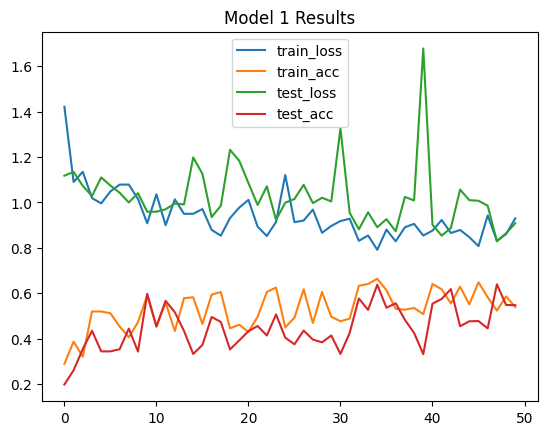

In [219]:
model_1_df = pd.DataFrame(model_1_results)
model_1_df.plot()
plt.title("Model 1 Results")